# Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. **Specifically, your goal is to maximize the following metrics:**

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

# Project Summary

<br>

### Questions

1)	Analyze the results of the experiment and identify the effect of the Treatment on product purchase and Net Incremental Revenue

2)	Build a model to select the best customers to target that maximizes the Incremental Response Rate and Net Incremental Revenue. 

# Project Pathway

### Part 1: Hypothesis Testing 
- The experiment is finished. Analyze it to see if giving out promotion helps with IRR and NIR
- Analyze = calculate the experiment's IRR, NIR
- Identify the effect of promotion = Test the hypothesese by boostrap 

### Part 2: Build a Model 
- Select customers whose features (V1 - V7) will maximize the IRR and NIR, give them the Promotion code (Treatment)
- This is a Feature Selection problem

## A. Review the Data

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import warnings

# ML packages
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

ID Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0   1        No         0   2  30.443518 -1.165083   1   1   3   2
1   3        No         0   3  32.159350 -0.645617   2   3   2   2
2   4        No         0   2  30.431659  0.133583   1   1   4   2
3   5        No         0   0  26.588914 -0.212728   2   1   4   2
4   8       Yes         0   3  28.044331 -0.385883   1   1   2   2

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
train_data.describe()

ID      purchase            V1            V2            V3  \
count   84534.000000  84534.000000  84534.000000  84534.000000  84534.000000   
mean    62970.972413      0.012303      1.500662     29.973600      0.000190   
std     36418.440539      0.110234      0.868234      5.010626      1.000485   
min         1.000000      0.000000      0.000000      7.104007     -1.684550   
25%     31467.250000      0.000000      1.000000     26.591501     -0.905350   
50%     62827.500000      0.000000      2.000000     29.979744     -0.039572   
75%     94438.750000      0.000000      2.000000     33.344593      0.826206   
max    126184.000000      1.000000      3.000000     50.375913      1.691984   

                 V4            V5            V6            V7  
count  84534.000000  84534.000000  84534.000000  84534.000000  
mean       1.679608      2.327643      2.502898      1.701694  
std        0.466630      0.841167      1.117349      0.457517  
min        1.000000      1.000000      1.000000      1.000000  
25%        1.000000      2.000000      2.000000      1.000000  
50%        2.000000      2.000000      3.000000      2.000000  
75%        2.000000      3.000000      4.000000      2.000000  
max        2.000000      4.000000      4.000000      2.000000

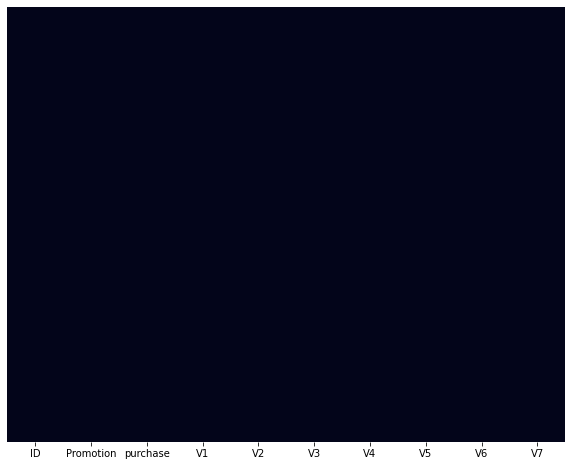

In [5]:
# Null values visualization
plt.figure(figsize=(10,8))
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False);

**Note**
- Shape: (84534, 10)
- No missing data
- Input: V1 - V7. How their pattern influence the decision to give out promotion?
- Outut: yes/no Promotion

## B. EDA

In [6]:
train_data.groupby(['Promotion','purchase'])['purchase'].count()

Promotion  purchase
No         0           41851
           1             319
Yes        0           41643
           1             721
Name: purchase, dtype: int64

<AxesSubplot:xlabel='Promotion', ylabel='count'>

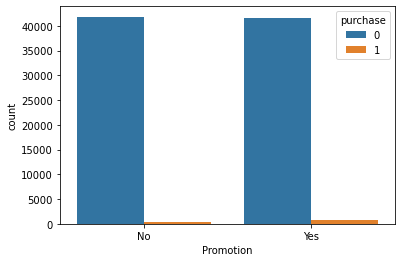

In [7]:
# Purchase portion made in each group
sns.countplot(train_data['Promotion'],hue=train_data['purchase'])

<AxesSubplot:xlabel='purchase', ylabel='count'>

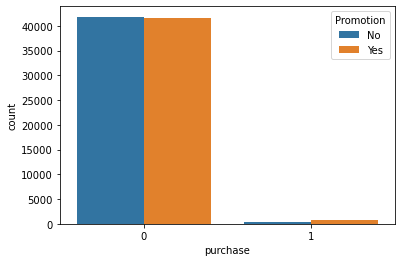

In [8]:
# Promotion received regarding purchase decision 
sns.countplot(train_data['purchase'],hue=train_data['Promotion'])

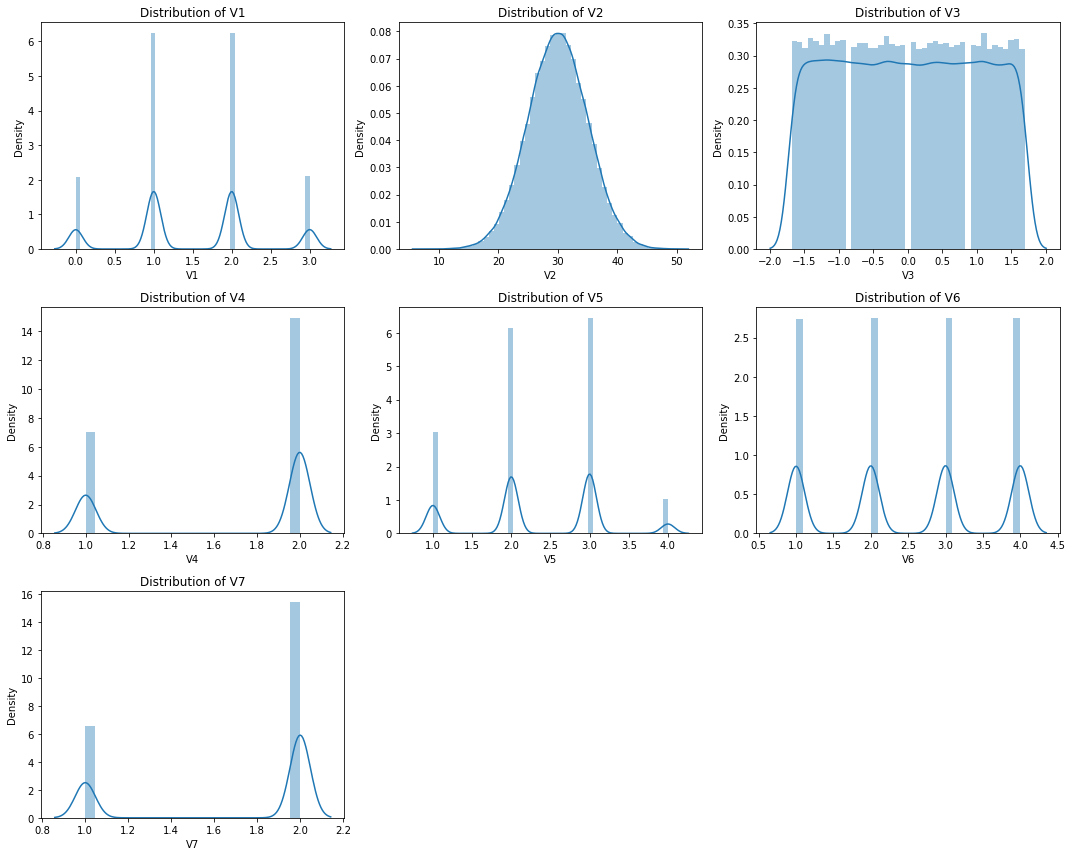

In [9]:
# Features V1-V7 df
features_df = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]

# Features distribution
plt.figure(figsize=(15,12))

i=1
for feature in features_df.columns:
    plt.subplot(3,3,i)
    sns.distplot(features_df[feature])
    plt.title('Distribution of {}'.format(feature))
    
    i +=1
    plt.tight_layout()

**Insights**
- Imbalanced data in 'purchase' col: No >>> Yes
- Separate the "promotion" group to see the influence of V1-V7 factors
- 'No purchase' portion is similar in both groups
- 'Yes purchase' portion is double in the group receving promotions 
<br>

- Promotion is categorical data type
- From V1-V7 distribution plots: V2 and V3 appears to be continuous. The rest can be categorical <br>
    --> Create dummy variables: Promotion, V1,V4-V7 (Data preparation)

In [10]:
# Duplicate the train dataset for visualization 
df = train_data.copy()
df.drop('ID',axis=1,inplace=True)
df.head()

Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
0        No         0   2  30.443518 -1.165083   1   1   3   2
1        No         0   3  32.159350 -0.645617   2   3   2   2
2        No         0   2  30.431659  0.133583   1   1   4   2
3        No         0   0  26.588914 -0.212728   2   1   4   2
4       Yes         0   3  28.044331 -0.385883   1   1   2   2

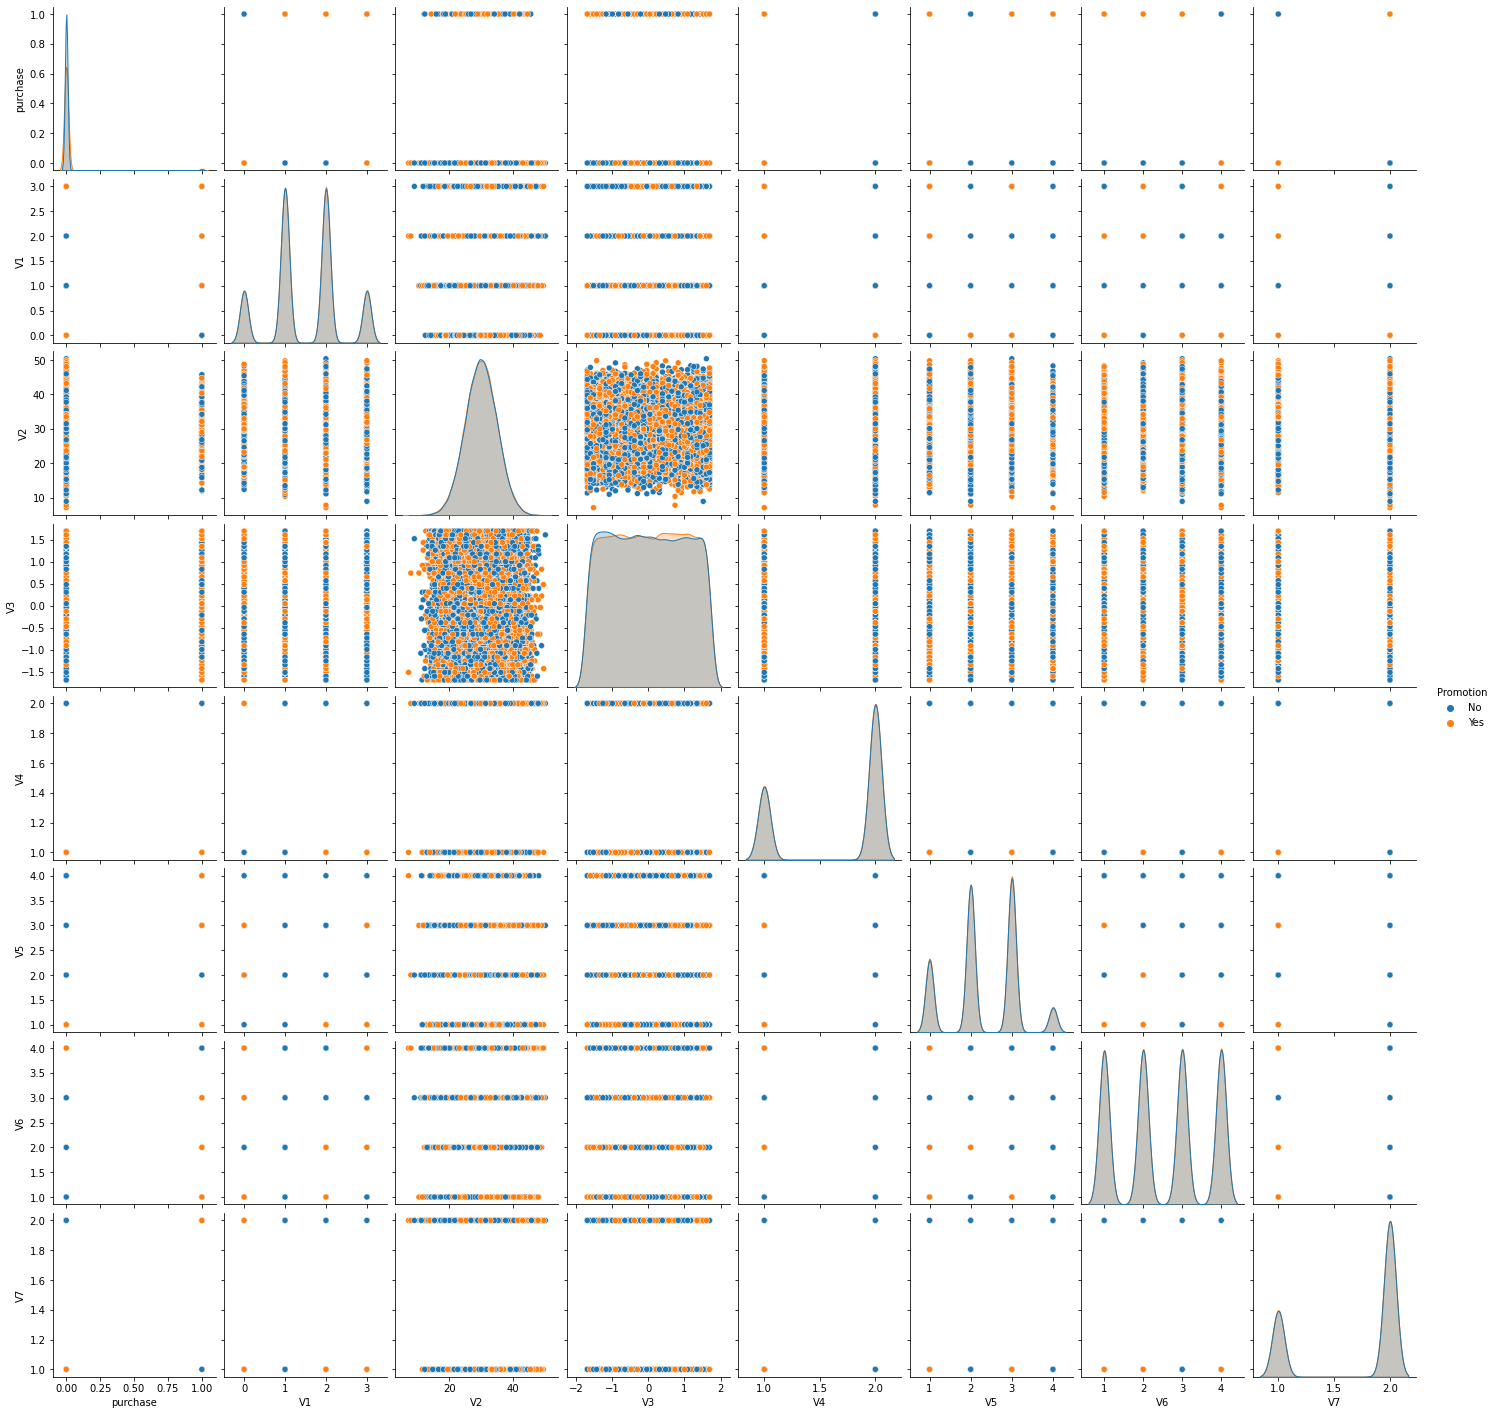

In [11]:
# Promotion and V1-V7
sns.pairplot(df,hue='Promotion')

In [12]:
# Create a df for group receiveing promotions
treat_grp = df[df['Promotion']=="Yes"]
treat_grp.head()

Promotion  purchase  V1         V2        V3  V4  V5  V6  V7
4        Yes         0   3  28.044331 -0.385883   1   1   2   2
8        Yes         0   2  31.930423  0.393317   2   3   1   2
10       Yes         0   1  32.770916 -1.511395   2   1   4   1
12       Yes         0   1  36.957009  0.133583   2   3   1   1
14       Yes         0   3  36.911714 -0.905350   2   2   4   1

In [13]:
treat_grp.shape

(42364, 9)

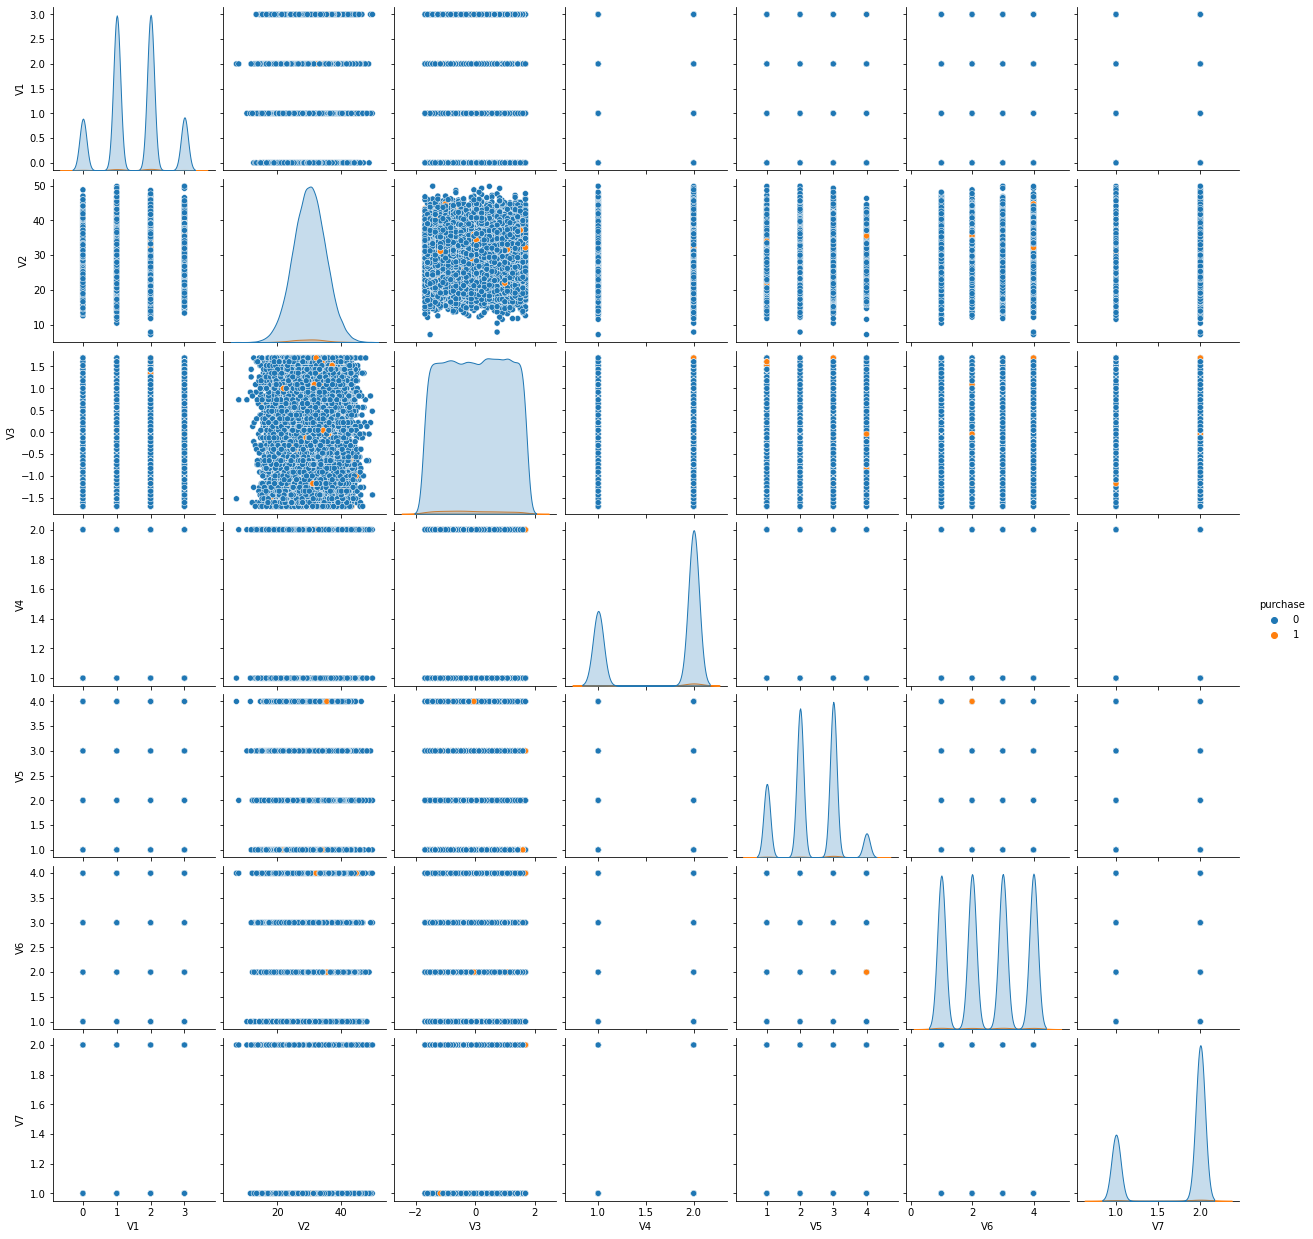

In [14]:
# In treat_grp: purchase and V1-V7 effect
sns.pairplot(treat_grp,hue='purchase')

**Insight:**
Even within the Treat group, the portion of customers purchase the item are very small and there is not a clear pattern demonstrated from the features

## C. Data Preparation

In [15]:
# Create dummy variables for: Promotion, V1, V4, V5, V6, V7
# for features
df_enc = pd.get_dummies(df,prefix_sep="_",columns=['V1','V4','V5','V6','V7'])
# for Promotion
label_encd = LabelEncoder()
df_enc['Promotion'] = label_encd.fit_transform(df_enc['Promotion'])

df_enc.head()

Promotion  purchase         V2        V3  V1_0  V1_1  V1_2  V1_3  V4_1  \
0          0         0  30.443518 -1.165083     0     0     1     0     1   
1          0         0  32.159350 -0.645617     0     0     0     1     0   
2          0         0  30.431659  0.133583     0     0     1     0     1   
3          0         0  26.588914 -0.212728     1     0     0     0     0   
4          1         0  28.044331 -0.385883     0     0     0     1     1   

   V4_2  V5_1  V5_2  V5_3  V5_4  V6_1  V6_2  V6_3  V6_4  V7_1  V7_2  
0     0     1     0     0     0     0     0     1     0     0     1  
1     1     0     0     1     0     0     1     0     0     0     1  
2     0     1     0     0     0     0     0     0     1     0     1  
3     1     1     0     0     0     0     0     0     1     0     1  
4     0     1     0     0     0     0     1     0     0     0     1

In [16]:
# Categorical or Features list
features_list = ['V1_0','V1_1','V1_2','V1_3','V4_1','V4_2','V5_1','V5_2','V5_3','V5_4',
                 'V6_1','V6_2','V6_3','V6_4','V7_1','V7_2']

In [17]:
data = [go.Heatmap(
        z= df_enc.corr().values,
        x= df_enc.columns.values,
        y= df_enc.columns.values,
        colorscale='RdBu_r',
        opacity = 1.0 )]

layout = go.Layout(
    title='Pearson Correlation of Input Features to Promtion and Purchase',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks=''),
    width = 700, height = 500)

fig = go.Figure(data=data, layout=layout)
fig.show()

# or a simpler static heatmap
#plt.figure(figsize=(14,10))
#sns.heatmap(df_enc.corr(),annot=True, cmap='coolwarm',fmt='.1g')

In [18]:
# Top 10 features that correlates with Promotion_Yes
df_enc.corr()['Promotion'].sort_values(ascending=False).head(10)

Promotion    1.000000
purchase     0.042884
V3           0.007269
V5_1         0.003267
V1_3         0.002975
V1_2         0.002921
V5_3         0.002716
V4_1         0.001416
V7_1         0.001115
V6_4         0.000857
Name: Promotion, dtype: float64

In [19]:
# Top 10 features that correlates with purchase
df_enc.corr()['purchase'].sort_values(ascending=False).head(10)

purchase     1.000000
Promotion    0.042884
V4_2         0.032245
V5_3         0.017661
V5_1         0.005945
V1_2         0.003579
V1_0         0.002358
V6_3         0.002069
V7_1         0.001117
V6_1         0.000825
Name: purchase, dtype: float64

**Insights from the correlation map** 
- High correlation with receiving promotion: purchase, V3, V5_1, V1_3, V1_2, V5_3, V4_1
- High correlation with making purchase: Promotion_Yes, V4_2, V5_3, V5_1, V1_2, V1_0
- Overlap features: V5_1, V5_3, V1_2

In [20]:
df_treat_enc = df_enc[df_enc['Promotion']==1]
df_treat_enc.head()

Promotion  purchase         V2        V3  V1_0  V1_1  V1_2  V1_3  V4_1  \
4           1         0  28.044331 -0.385883     0     0     0     1     1   
8           1         0  31.930423  0.393317     0     0     1     0     0   
10          1         0  32.770916 -1.511395     0     1     0     0     0   
12          1         0  36.957009  0.133583     0     1     0     0     0   
14          1         0  36.911714 -0.905350     0     0     0     1     0   

    V4_2  V5_1  V5_2  V5_3  V5_4  V6_1  V6_2  V6_3  V6_4  V7_1  V7_2  
4      0     1     0     0     0     0     1     0     0     0     1  
8      1     0     0     1     0     1     0     0     0     0     1  
10     1     1     0     0     0     0     0     0     1     1     0  
12     1     0     0     1     0     1     0     0     0     1     0  
14     1     0     1     0     0     0     0     0     1     1     0

<AxesSubplot:>

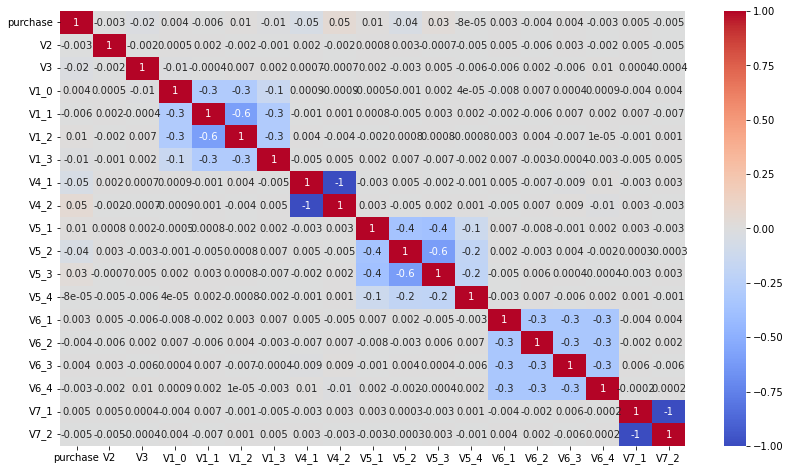

In [21]:
# Features correlation within exp group
plt.figure(figsize=(14,8))
sns.heatmap(df_treat_enc.drop(['Promotion'],axis=1).corr(),annot=True, cmap='coolwarm',fmt='.1g')

In [22]:
# Top 10 features within treat group that correlates with purchase
df_treat_enc.corr()['purchase'].sort_values(ascending=False).head(10)

purchase    1.000000
V4_2        0.053348
V5_3        0.029869
V5_1        0.012088
V1_2        0.011833
V7_1        0.005005
V1_0        0.004468
V6_3        0.003876
V6_1        0.003376
V5_4       -0.000084
Name: purchase, dtype: float64

## D. Data Analysis

### Objectives

We have a dataframe containing processed data (clean, dummied, binary) that are ready for analysis.

**1. Hypothesis testing: Does Promotion increase IRR and NIR on the conducted experiment?**
- Includes tests on: invariant (50/50 split) metric and evaluation metrics (IRR and NIR)
- What are the IRR and NIR from the experiment?
- Is Promotion working? Answer via p-values of IRR's and NIR's distribution
    - Remind: z-score and p-value are measures from a distribution.
    - This indicates that we need to create a distribution for IRR and NIR
    - Doing so by boostrapping 
- ?! Go deeper by isolating each feature, then test their effect on the the IRR and NIR.
    - Does each feature individually improve IRR and/or NIR?

**2. Build a model** to select the best customers to target that maximizes the IRR and NIR, aka customers with best features (V1 - V7)
- Input (x): features V1_1, V1_2,...,V7_2
- Output (y): promotion yes or no 

## D1. Hypothesis Testing

Invariant metric: Size of control and treated groups 

Evaluation metrics: IRR and NIR

### D1.a. Invariant metric

**Is there a statistically significant differente between 2 groups size?**

Check if the number of custormers in control group is the same as in treated group. 
<br>

**Hypothesis**

$$ H_{o}: n_{control} = n_{treated} $$
$$ H_{a}: n_{control} != n_{treated} $$
alpha = 0.05

In [23]:
def test_invariant_metric(df, feature):
    # control group size
    n_control = df[df['Promotion']==0].shape[0]
    
    # treated group size
    n_treat = df[df['Promotion']==1].shape[0]
    
    # total observation
    n_obs = df.shape[0]
    
    
    ## simulate outcomes under null, compare to observed outcome
    p = 0.5
    n_trials = 200_000
    
    samples = np.random.binomial(n_obs, p, n_trials)
    p_value = np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean()
    
    return p_value

In [24]:
# Invariant metric test on the given data set
test_invariant_metric(df_enc,'Promotion')

0.50777

### D1.b Evaluation Metrics

There are two evaluation metrics, IRR (Incremental Response Rate) and NIR (Net Incremental Rate). 

#### Incremental Response Rate (IRR)

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

In [25]:
def cal_irr(df):
    """
    Calculate the IRR 
    
    INPUT: a dataframe contains the records of receiving promotion and making purchase 
    
    OUTPUT: a value (float) represents the number of customers purchased the product with the promotion, 
            as compared to if they didn't receive the promotion
    """
    
    cust_treat = df[df['Promotion'] == 1].shape[0]
    cust_ctrl = df[df['Promotion'] == 0].shape[0]
    
    purch_treat = df[df['Promotion'] == 1]['purchase'].sum()
    purch_ctrl = df[df['Promotion'] == 0]['purchase'].sum()
    
    irr = (purch_treat/cust_treat) - (purch_ctrl/cust_ctrl)
    
    return irr

In [26]:
# Calculate the IRR from dummied df
IRR = cal_irr(df_enc)
print('The IRR is: ',round(IRR,6))

The IRR is:  0.009455


#### Net Incremental Revenue (NIR)

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [27]:
def cal_nir(df):
    """
    Calculate the NIR 
    
    INPUT: a dataframe contains the records of receiving promotion and making purchase 
    
    OUTPUT: a value (float) represents how much is made (or lost) by sending out the promotion
    """
    
    cust_treat = df[df['Promotion'] == 1].shape[0]
    
    purch_treat = df[df['Promotion'] == 1]['purchase'].sum()
    purch_ctrl = df[df['Promotion'] == 0]['purchase'].sum()
    
    nir = (10*purch_treat - 0.15*cust_treat) - 10*purch_ctrl
    
    return nir

In [28]:
# Calculate the NIR from dummied df
NIR = cal_nir(df_enc)
print('The NIR is: ',round(NIR,6))

The NIR is:  -2334.6


#### Hypothesis

Consider the overall type I error rate is $$ alpha_{overall} = 0.05 $$

Apply the Bonferroni correction, we will arrive at type I error rate for each metric is 0.025. $$ alpha_{IRR} = alpha_{NIR} = \frac{alpha_{overall}}{2} = 0.025 $$

We hypothesize that by applying the promotions, the IRR and NIR will increase in sale for that specific product.

Hypotheses:

$$ H_{o}: IRR = 0 $$
$$ H_{a}: IRR > 0 $$

$$ H_{o}: NIR = 0 $$
$$ H_{a}: NIR > 0 $$

In [29]:
def test_evaluation_metrics(df, feature, alpha = 0.025, c = 0.95, n_trials = 1000):
    """
    A function to test a hypothesis 
    Compute a p-value and a confidence interval of the evaluation metrics using a bootstrap method.
    
    Input parameters:
    
    Output value
    """
    
    n_points = df.shape[0]
    sample_irrs = []
    sample_nirs = []
    
    for i in range(n_trials):
        # draw a random boostrapped sample set with replacement 
        sample = df.sample(n=n_points, replace=True)
        
        # calculate the evaluation metrics: IRRs and NIRs
        sample_irr = cal_irr(sample)
        sample_nir = cal_nir(sample)
        
        # append the calculated values to the lists
        sample_irrs.append(sample_irr)
        sample_nirs.append(sample_nir)    
    
    ## Compute p-value
    p_irrs = 1 - stats.norm.cdf(IRR, loc=0, scale=np.std(sample_irrs))
    p_nirs = 1 - stats.norm.cdf(NIR, loc=0, scale=np.std(sample_nirs))    
    
    return (p_irrs,p_nirs)

In [30]:
# Evaluation metrics test on the given data set
test_evaluation_metrics(df_enc,'Promotion')

(0.0, 0.999999999999818)

**Results** On the given training data set:
- p-value IRR = 0.0 -> Reject Ho -> Increase purchase rate
- p-value NIR = 0.99999 -> Do not reject Ho -> NIR = 0

### D1.c. Conclusion

By testing the hypotheses on the resutls of the experiment, we prove and learn that:
- There is no significant difference in sample size between control and treated groups
- Giving out promotion will drive up the purchase rate. 
- However, there is no net positive revenue generated.

- When each feature V1 - V7 is isolated, the same conclusion is received

### D1.d. IRR and NIR Distributions

In [33]:
# IRRs and NIRs distributions

n_points = df_enc.shape[0]
sample_irrs = []
sample_nirs = []

for i in range(1000):
    # draw a random boostrapped sample set with replacement 
    sample = df_enc.sample(n=n_points, replace=True)
    
    # calculate the evaluation metrics: IRRs and NIRs
    sample_irr = cal_irr(sample)
    sample_nir = cal_nir(sample)
    
    # append the calculated values to the lists
    sample_irrs.append(sample_irr)
    sample_nirs.append(sample_nir)

In [34]:
def metric_distribution(metric, sample):
    
    # Confidence interval (CI)
    lower_limit = np.percentile(sample, (1 - .975)/2 * 100)
    upper_limit = np.percentile(sample, (1 + .975)/2 * 100)
    
    # distribution under null hypothesis (mean is 0)
    null_metric = np.random.normal(0, np.std(sample), 10000)
    plt.hist(null_metric, bins=60)
    plt.title("Normal Distribution under the Null Hypothesis")
    
    plt.axvline(metric, color='g', linestyle='dotted', label="Observed Statistic")
    
    plt.axvline(lower_limit, color='r')
    plt.axvline(upper_limit, color='r')
    plt.text(lower_limit+0.0005, 300, 'Sample \n Confidence \n Interval', ma='center')
    plt.legend();

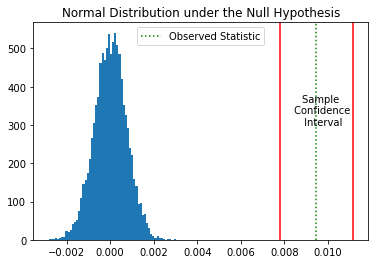

In [35]:
# For IRRs
metric_distribution(IRR, sample_irrs)

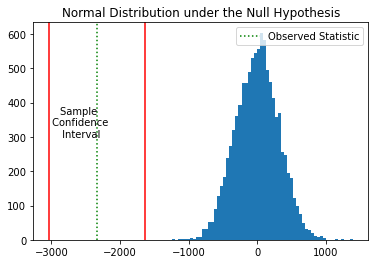

In [36]:
# for NIRs
metric_distribution(NIR,sample_nirs)

### D1.e. Hypothesis testing for Each Feature

Isolating each feature will create a sub dataframe. 

Then test the hypotheses (invariant and evaluation metrics) on the sub dfs to see each feature effects on the IRR and NIR

#### Ivanriant metric - group size

In [37]:
p_dic = {}
for feature in features_list:
    sub_df = df_enc[df_enc[feature]==1]
    p_value = test_invariant_metric(sub_df,feature)
    
    p_dic.update({feature:p_value})

# summary the feature and p value pairs in a df
size_df = pd.DataFrame(sorted(p_dic.items(), key=lambda x: x[1], reverse=True),columns=['Feature','p-value'])

# add a decision column 
size_df['Reject Ho'] = size_df['p-value'] < 0.05

size_df

Feature   p-value  Reject Ho
0     V1_0  1.000000      False
1     V1_1  1.000000      False
2     V5_2  1.000000      False
3     V5_4  1.000000      False
4     V6_1  0.950450      False
5     V6_2  0.767535      False
6     V4_2  0.755315      False
7     V7_2  0.704390      False
8     V6_3  0.685585      False
9     V6_4  0.586520      False
10    V7_1  0.526995      False
11    V4_1  0.477790      False
12    V5_3  0.303845      False
13    V1_3  0.302135      False
14    V1_2  0.281350      False
15    V5_1  0.255940      False

#### Evaluation metrics - IRR and NIR

In [39]:
p_values_dic = {}

for feature in features_list:
    sub_df = df_enc[df_enc[feature]==1]
    p_values = test_evaluation_metrics(sub_df,feature)
    
    p_values_dic.update({feature:p_values})
    
# summary the feature-p value pairs in a df
b = pd.DataFrame(p_values_dic,index=['p-value for IRRs','p-value for NIRs'])
eval_df = pd.DataFrame.transpose(b)

# add 2 decision columns
eval_df['Reject Ho_IRRs'] = eval_df['p-value for IRRs'] < 0.025
eval_df['Reject Ho_NIRs'] = eval_df['p-value for NIRs'] < 0.025

In [40]:
eval_df

p-value for IRRs  p-value for NIRs  Reject Ho_IRRs  Reject Ho_NIRs
V1_0      1.331232e-05               1.0            True           False
V1_1      8.215650e-15               1.0            True           False
V1_2      3.563816e-14               1.0            True           False
V1_3      3.078482e-07               1.0            True           False
V4_1      0.000000e+00               1.0            True           False
V4_2      0.000000e+00               1.0            True           False
V5_1      1.658420e-07               1.0            True           False
V5_2      0.000000e+00               1.0            True           False
V5_3      5.053735e-13               1.0            True           False
V5_4      1.598037e-03               1.0            True           False
V6_1      2.057710e-11               1.0            True           False
V6_2      1.723405e-10               1.0            True           False
V6_3      3.477668e-10               1.0            True           False
V6_4      1.214314e-10               1.0            True           False
V7_1      6.616041e-12               1.0            True           False
V7_2      0.000000e+00               1.0            True           False

#### Conclusion

By testing the hypotheses on each feature V1 - V7, the same result is received:
- There is no significant difference in sample size between control and treated groups
- Giving out promotion will drive up the purchase rate, but no net positive revenue generated.

## D2. Features Selection

For every feature:
- create a sub df
- calculate IRR and NIR
- store then sort them in the descending order, where feature with high values stay on top 

In [41]:
irr_dic = {}
nir_dic = {}

for feature in features_list:
    
    # slice out a df when a feature is true (=1)
    sub_df = df_enc[df_enc[feature]==1]
    
    # calculate irr
    irr = cal_irr(sub_df)
    irr_dic.update({feature:irr})
    
    # calculate nir
    nir = cal_nir(sub_df)
    nir_dic.update({feature:nir})

# sort the IRR and NIR dictionaries 
irr_dic = sorted(irr_dic.items(), key=lambda x: x[1], reverse=True)
nir_dic = sorted(nir_dic.items(), key=lambda x: x[1], reverse=True)

# organize them in dataframes
IRR_df = pd.DataFrame(irr_dic,columns=['Feature IRR_max','IRR'])
NIR_df = pd.DataFrame(nir_dic,columns=['Feature NIR_max','NIR'])
feature_ranking = pd.concat([IRR_df,NIR_df],axis=1)

feature_ranking

Feature IRR_max       IRR Feature NIR_max      NIR
0             V5_3  0.014308            V5_3   -99.75
1             V4_2  0.014060            V5_1  -116.55
2             V5_1  0.013375            V5_4  -169.95
3             V1_2  0.012437            V1_0  -212.45
4             V7_1  0.011083            V4_2  -264.45
5             V1_0  0.011062            V1_2  -395.00
6             V6_1  0.010642            V6_1  -457.70
7             V6_3  0.010407            V6_3  -483.45
8             V6_4  0.009167            V7_1  -488.85
9             V7_2  0.008762            V1_3  -498.35
10            V5_4  0.008674            V6_4  -614.20
11            V6_2  0.007610            V6_2  -779.25
12            V1_1  0.007245            V1_1 -1228.80
13            V1_3  0.005608            V7_2 -1845.75
14            V5_2  0.002511            V5_2 -1948.35
15            V4_1 -0.000284            V4_1 -2070.15

In [42]:
# select object columns
feature_ranking.select_dtypes(include='object')

Feature IRR_max Feature NIR_max
0             V5_3            V5_3
1             V4_2            V5_1
2             V5_1            V5_4
3             V1_2            V1_0
4             V7_1            V4_2
5             V1_0            V1_2
6             V6_1            V6_1
7             V6_3            V6_3
8             V6_4            V7_1
9             V7_2            V1_3
10            V5_4            V6_4
11            V6_2            V6_2
12            V1_1            V1_1
13            V1_3            V7_2
14            V5_2            V5_2
15            V4_1            V4_1

**Insights**
- Once again, we see that the Promotion icreases the purchases rate but not the net profit. 
- Top 5 features that maximize NIR are: V5_3, V5_1, V5_4, V1_0, V4_2
- Top 5 features that maximize IRR are: V5_3, V4_2, V5_1, V1_2, V7_1


_ Recall: we have a highly imbalance data in Purchase column

## E. Model

## E1. Thought process

1. Write a custom model incorporating the findings of best features above
    - customers who score on top features will get the Promotion 
    
**ML Model for strategy**

2. Which classification model fits well for the given data set?
    - *Note*: the ML model will predict the 'purchase'
    - I made a mistake thinking a ML model will predict the Promotion. But NO the Promotion is an invariant metric. If pursuing a ML model, it is for predicting if the customer purchase the product.
3. This model is used to predict the 'purchase' -> get the promotion

## E2. Custom Promotion Strategy

Overall, we see that this promotion costs Starbucks (net negative) but does increase sale a bit. For the purpose of minimizing the loss, I'm going to prioritize the promotion to customers whose features associating with small NIR and overlap with high IRR

The features chosen for receiving promotion will be: V5_3, V5_1, V5_4, V4_2, V1_0, V1_2

In [43]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    promotion = []
    for index, row in df.iterrows():
        
        if row['V1'] == 0 or row['V1'] == 2:
            if row['V4'] == 2:
                if row['V5'] == 1 or row['V5'] == 3 or row['V5'] == 4:
                    promotion.append('Yes')
                else:
                    promotion.append('No')
            else:
                promotion.append('No')
        else:
            promotion.append('No')

    # Casting into a Numpy array
    promotion = np.asarray(promotion)

    print("Size of Promotion population: {}".format(len(promotion)))

    return promotion

In [44]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Size of Promotion population: 41650
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0212.

Your nir with this strategy is 266.85.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.021171891588221137, 266.85)

## E3. ML Classification Models for Predicting Customer Purchase

In [45]:
# create another copy from the original data set
df_ml = train_data.copy()

In [46]:
df_ml.drop(['ID','Promotion'],axis=1,inplace=True)

In [47]:
df_ml.head()

purchase  V1         V2        V3  V4  V5  V6  V7
0         0   2  30.443518 -1.165083   1   1   3   2
1         0   3  32.159350 -0.645617   2   3   2   2
2         0   2  30.431659  0.133583   1   1   4   2
3         0   0  26.588914 -0.212728   2   1   4   2
4         0   3  28.044331 -0.385883   1   1   2   2

### E3.a. Train - test Split

In [48]:
X = df_ml.drop(['purchase'],axis=1)
y = df_ml['purchase']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We are having a highly imbalanced data set. I'm going to:
- use SMOTE to sythetically create more samples in a balanced way
- compare the performance of three classfications models: Logistic regression (basic), Balanced random forest classifier, and xgboost.

In [50]:
# Upsampling with SMOTE
oversample = SMOTE()
X_train_ups, y_train_ups = SMOTE(sampling_strategy='minority', random_state=42).fit_resample(X_train, y_train)

### E3.b. Train the models

In [51]:
# Instantiate the models 
log = LogisticRegression().fit(X_train_ups,y_train_ups)
brfc = BalancedRandomForestClassifier().fit(X_train_ups,y_train_ups)
xgb = XGBClassifier(learning_rate=0.1, objective = 'binary:logistic').fit(X_train_ups,y_train_ups)

[23:59:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
models = [log, brfc, xgb]
model_name = ['Logistic Regression','Balance Random Forest','XGBoost']

In [53]:
# Apply cross validation with k=10 for each model

scoring = ['accuracy','precision','recall']
train_accuracy = []
train_precision = []
train_recall = []
train_std = []

train_scoring = {}
for model in models:
    scores = cross_validate(model, X_train_ups, y_train_ups, cv=10, scoring=scoring)
    
    # ignore the first two columns from scoring which are fit_time and score_time
    # pay attention to the breakdown in the Cross validation section
    train_accuracy.append(scores['test_accuracy'].mean())
    train_precision.append(scores['test_precision'].mean())
    train_recall.append(scores['test_recall'].mean())
    train_std.append(scores['test_accuracy'].std())
    
    train_scoring.update({model:scores['test_accuracy']})

[00:02:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:03:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [54]:
# Performance of 3 models on training set
train_scores = pd.DataFrame(list(zip(train_accuracy,train_precision,train_recall,train_std)),
                            index=model_name,columns=['Accuracy','Precision','Recall','Standard Deviation'])
print('Models Training Scores')
train_scores

Models Training Scores


Accuracy  Precision    Recall  Standard Deviation
Logistic Regression    0.583527   0.584725  0.576248            0.005384
Balance Random Forest  0.965144   0.951853  0.979864            0.006716
XGBoost                0.964074   0.969977  0.957881            0.017642

### E3.c. Test the Models

In [55]:
accuracy_scores = []
precision_scores = []
recall_scores = []
error_rate = []

for i,model in enumerate (models):
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test,y_pred)
    
    print('\n')
    print(model_name[i])
    print(classification_report(y_test,y_pred))
    '\n'
    print(conf_matrix)
    
    tn = conf_matrix[0,0]
    fp = conf_matrix[0,1]
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    
    total = tn + fp + tp + fn

    accuracy  = (tp + tn) / total # Accuracy Rate
    precision = tp / (tp + fp) # Positive Predictive Value
    recall    = tp / (tp + fn) # True Positive Rate
    error = (fp + fn) / total # Missclassification Rate
 
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    error_rate.append(error)



Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     25040
           1       0.01      0.44      0.03       321

    accuracy                           0.59     25361
   macro avg       0.50      0.52      0.38     25361
weighted avg       0.98      0.59      0.73     25361

[[14754 10286]
 [  179   142]]


Balance Random Forest
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     25040
           1       0.01      0.04      0.02       321

    accuracy                           0.94     25361
   macro avg       0.50      0.50      0.49     25361
weighted avg       0.97      0.94      0.96     25361

[[23756  1284]
 [  307    14]]


XGBoost
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     25040
           1       0.02      0.07      0.04       321

    accuracy                           0.95     25361
   macro a

In [56]:
# Performance of 3 models on Test set
scores_df = pd.DataFrame(list(zip(accuracy_scores,precision_scores,recall_scores,error_rate)),index=model_name,columns=['Accuracy','Precision','Recall','Error Rate'])
print('Models Evaluation from Test Set')
scores_df

Models Evaluation from Test Set


Accuracy  Precision    Recall  Error Rate
Logistic Regression    0.587359   0.013617  0.442368    0.412641
Balance Random Forest  0.937266   0.010786  0.043614    0.062734
XGBoost                0.950515   0.024440  0.074766    0.049485

**Insights**
BRFC and XGBoost perform well with scaled-up data set. XGBoost seems to perform better than BRFC 

In [60]:
def promotion_strategy_ml(df):
    
    promotion_yes_no = []
    
    #y_pred = brfc.predict(df)  
    y_pred = xgb.predict(df)
    for value in y_pred:
        if value == 0:
            promotion_yes_no.append("No")
        if value == 1:
            promotion_yes_no.append("Yes")

    # Casting into a Numpy array
    promotion = np.asarray(promotion_yes_no)

    print("Size of Promotion population: {}".format(len(promotion)))

    return promotion

In [61]:
# BRFC result
test_results(promotion_strategy_ml)

Size of Promotion population: 41650
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0043.

Your nir with this strategy is -110.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0043122197201532035, -110.6)

In [59]:
# Xgboost result
# comment out line 5 in the code above
test_results(promotion_strategy_ml)

Size of Promotion population: 41650
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0256.

Your nir with this strategy is 87.15.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.025574535475525573, 87.15)

## E4. Conclusion

- The custom strategy in which certain features are targeted maximizes the IRR and NIR most (0.0212 , 266.85) and outperform Udacity's model (0.0188 , 189.45)
- Xgboost algorithm produce a positive NIR value in constrast with BRFC, thus will be chosen as a ML model for this problem. The IRR and NIR prouduced are (0.0256 , 87.15)

- Despite a high performace, the custom strategy may not be the best practice in production. It is most effective when there are manageable amount of features. The way to go is to apply a ML model to learn the features and make prediction.
